In [1]:
import networkx as nx
import pandas as pd
from datetime import datetime
import numpy as np
from numpy.random import rand
from numpy import exp
import matplotlib.pyplot as plt

In [2]:
G = nx.read_gml("municipios_br.gml")
G = nx.relabel_nodes(G,lambda x: int(x))

In [3]:
data_dict = dict(G.nodes.data("CD_MUN"))

In [4]:
data = pd.read_csv('caso_full.csv')

In [5]:
data = data[(data['city'].isnull() == False) & (data['is_repeated'] == False)]
a = ['city_ibge_code','order_for_place','date','epidemiological_week',
 'last_available_confirmed_per_100k_inhabitants','last_available_confirmed',
 'last_available_death_rate']
columns_to_drop = ['state','city','place_type','last_available_confirmed',
                   'last_available_date','estimated_population',
                  'is_last','is_repeated']
data.drop(columns=columns_to_drop,inplace=True)
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')
data.epidemiological_week -= data.epidemiological_week.min()

In [6]:
grouped = data[["last_available_confirmed_per_100k_inhabitants","city_ibge_code","date"]].groupby('city_ibge_code')

In [7]:
n = data["city_ibge_code"].nunique()
codes = data["city_ibge_code"].unique()

In [8]:
min_date = data["date"].min()
max_date = data["date"].max()

In [9]:
max_date

Timestamp('2021-10-07 00:00:00')

In [10]:
delta = max_date - min_date

In [11]:
dates = pd.date_range(start=min_date, end=max_date, freq='D')
i = 0
X = np.zeros((len(grouped),delta.days + 1))
for group, data in grouped:
    series = data[["last_available_confirmed_per_100k_inhabitants","date"]]
    series = series.set_index("date").reindex(dates).interpolate().ffill().fillna(0)
    shape = series.shape
    X[i,:] = series.values.reshape(len(series))
    if data_dict[i] != str(group)[:-2]:
        print(data_dict[i],group)
    i += 1

In [12]:
zeros = np.zeros(len(grouped), dtype=bool)
true_indices = np.random.choice(len(grouped),2)
np.put(zeros,true_indices,True)
zeros

array([False, False, False, ..., False, False, False])

In [13]:
def gen_candidate_no_constraint(nodes,curr):
    candidate = curr
    curr_idx = np.nonzero(curr)[0]
    leave_basis = np.random.choice(curr_idx)
    candidate[leave_basis] = False
    #enter_basis = np.random.choice(np.where(candidate == False)[0],1)
    enter_basis = np.random.choice(np.append(nodes,leave_basis),1)
    candidate[enter_basis] = True
    return candidate

In [14]:
def gen_candidate_with_constraint(G,nodes,curr):
    candidate = gen_candidate_no_constraint(nodes.copy(),curr.copy())
    #print(np.count_nonzero(candidate),len(nodes))
    curr_idx = np.nonzero(candidate)[0]
    SG = G.subgraph(curr_idx)
    while not nx.is_connected(SG):
        candidate = gen_candidate_no_constraint(nodes.copy(),curr.copy())
        curr_idx = np.nonzero(candidate)[0]
        SG = G.subgraph(curr_idx)
        #print(np.count_nonzero(candidate),len(nodes),e,l)
    return candidate

In [15]:
def reachble_nodes(G,curr_idx):
    U = set()
    queuque = list(curr_idx)
    while len(queuque) > 0:
        v = queuque.pop(0)
        if v not in U:
            U.add(v)
            neighbors = dict(nx.bfs_successors(G, source=v, depth_limit=1))[v]
            queuque.extend(neighbors)
    return list(U)

In [16]:
def generate_candidate(nodes,curr,constraint=False):
    curr_idx = np.nonzero(curr)[0]
    if constraint:
        a = reachble_nodes(G,curr_idx)
        possible_choices = np.delete(a,np.isin(a,curr_idx))
        return gen_candidate_with_constraint(G,possible_choices,curr)
    else:
        possible_choices = np.delete(nodes,np.isin(nodes,curr_idx))
        return gen_candidate_no_constraint(possible_choices,curr)

In [17]:
def powerLaw(T,i):
    return T*(0.995**i) 
def linear(T,i):
    return T - 10*i/9 + 1e-5
def log(T,i):
    return T/np.log(i+np.e) - 250*i/1800
update_strategies = [powerLaw,linear,log]

In [18]:
def generate_candidate0(len_x,k,constraint=False):
    best = np.zeros(len_x, dtype=bool)
    if constraint:
        ini = np.random.choice(len_x,1)[0]
        U = set()
        queuque = [ini]
        total = 0
        while total < k:
            v = queuque.pop(0)
            if v not in U:
                U.add(v)
                total += 1
                neighbors = dict(nx.bfs_successors(G, source=v, depth_limit=1))[v]
                queuque.extend(neighbors)
        np.put(best,list(U),True)
        return best
    else:
        true_indices = np.random.choice(len_x,k)
        np.put(best,true_indices,True)
        return best

In [19]:
def objective(X,choice):
    return -np.linalg.slogdet(np.cov(X[choice,:]))[1]

# simulated annealing algorithm
def simulated_annealing(objective, n_iterations, temp, X, k,update_estrategy=linear,constraint=False,ini=[]):
    # generate an initial point
    len_x = X.shape[0]
    nodes = np.arange(len_x)
    best = ini
    if len(best) == 0:
        best = generate_candidate0(len_x,k,constraint)
    values = []
    # evaluate the initial point
    best_eval = objective(X,best)
    # current working solution
    curr, curr_eval = best, best_eval
    print(">>>",best_eval,np.count_nonzero(curr==ini))
    # run the algorithm
    for i in range(n_iterations):
        # take a step
        candidate = generate_candidate(nodes,curr,constraint)
        # evaluate candidate point
        candidate_eval = objective(X.copy(),candidate)
        # check for new best solution
        if candidate_eval < best_eval:
            # store new best point
            best, best_eval = candidate, candidate_eval
            # report progress
            values.append(best_eval)
            #print('>%d f(%s) = %.5f' % (i, best, best_eval))
        # difference between candidate and current point evaluation
        diff = candidate_eval - curr_eval
        # calculate temperature for current epoch
        t = update_estrategy(temp,i)
        # calculate metropolis acceptance criterion
        metropolis = exp(-diff / t)
        # check if we should keep the new point
        if diff < 0 or rand() < metropolis:
            # store the new current point
            curr, curr_eval = candidate, candidate_eval
    return [best, best_eval, values]

In [21]:
# define the total iterations
n_iterations = 1800
# initial temperature
temp = 2000
k = 300
len_x = X.shape[0]
ini = generate_candidate0(len_x,k,False)

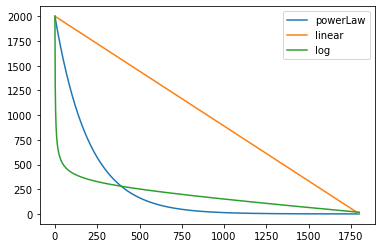

In [21]:
iters = np.arange(1800)
for s in update_strategies:
    v = np.vectorize(s)
    t = v(temp,iters)
    plt.plot(t,label=s.__name__)
plt.legend()
plt.show()

-2044.6475591455205 powerLaw
>>> -2044.6475591455205 5570
-2044.6475591455205 linear
>>> -2044.6475591455205 5570
-2044.6475591455205 log
>>> -2044.6475591455205 5570


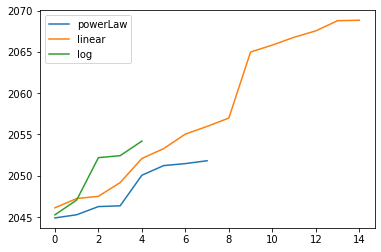

In [22]:
for estrategy in update_strategies:
    Y = X.copy()
    print(objective(Y,ini),estrategy.__name__)
    best, best_eval, values = simulated_annealing(objective, n_iterations, temp, Y, 300,
                                                  update_estrategy=estrategy,ini=ini.copy())
    plt.plot(np.abs(values),label=estrategy.__name__)
plt.legend()
plt.show()

In [23]:
#!pip install libpysal
#!pip install geopandas
import geopandas as gpd
municipios = gpd.read_file('BR_Municipios_2020/BR_Municipios_2020.shp')
m = municipios.geometry.to_crs(epsg=5641)
centroids = np.column_stack((m.centroid.x, m.centroid.y))
positions = dict(zip(G.nodes, centroids))

In [24]:
color_map = []
idx = np.nonzero(best)[0]
for node in G:
    if node in idx:
        color_map.append('blue')
    else: 
        color_map.append('green') 

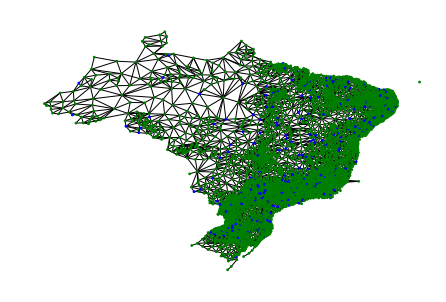

In [25]:
nx.draw(G, positions, node_color=color_map, with_labels=False,node_size=3)
plt.show()

In [27]:
nx.is_connected(G.subgraph(np.nonzero(best)[0])) 

False

-1801.2875516604227 powerLaw
>>> -1801.2875516604227 5570
True
-1801.2875516604227 linear
>>> -1801.2875516604227 5570
True
-1801.2875516604227 log
>>> -1801.2875516604227 5570
True


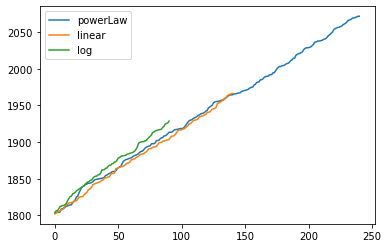

In [28]:
ini = generate_candidate0(len_x,k,True)
for estrategy in update_strategies:
    Y = X.copy()
    print(objective(Y,ini),estrategy.__name__)
    best, best_eval, values = simulated_annealing(objective, n_iterations, temp, Y, 300,
                                                  update_estrategy=estrategy,constraint=True,ini=ini.copy())
    plt.plot(np.abs(values),label=estrategy.__name__)
    print(nx.is_connected(G.subgraph(np.nonzero(best)[0]))) 
plt.legend()
plt.show()

In [29]:
color_map = []
idx = np.nonzero(best)[0]
for node in G:
    if node in idx:
        color_map.append('blue')
    else: 
        color_map.append('green') 

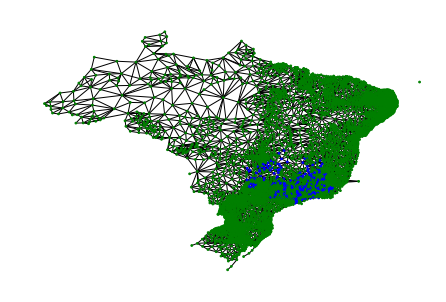

In [30]:
nx.draw(G, positions, node_color=color_map, with_labels=False,node_size=3)
plt.show()

In [22]:
# !pip install cvxpy
import cvxpy as cp

In [23]:
C = np.cov(X)

In [24]:
np.save("cov_matrix",C)

In [25]:
np.save("ts_matrix",X)

In [37]:
x = cp.Variable(len_x)
constraints = [cp.sum(x) == 300,x<=1,0<=x]
obj = cp.Maximize(cp.log_det(C@cp.diag(x)@C))

In [38]:
p = cp.Problem(obj,constraints)

In [ ]:
p.solve()

In [45]:
!pip install cvxopt

     |████████████████████████████████| 12.7 MB 4.5 MB/s eta 0:00:01


In [24]:
!pip install pyscipopt

  Using cached PySCIPOpt-4.2.0.tar.gz (661 kB)
  ERROR: Command errored out with exit status 1:
   command: /home/dell/anaconda3/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-x8zftmma/pyscipopt_9e5c8f47057b4c6b96a83bf9bc16c93b/setup.py'"'"'; __file__='"'"'/tmp/pip-install-x8zftmma/pyscipopt_9e5c8f47057b4c6b96a83bf9bc16c93b/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-zg4rppuw
       cwd: /tmp/pip-install-x8zftmma/pyscipopt_9e5c8f47057b4c6b96a83bf9bc16c93b/
  Complete output (39 lines):
  Assuming that SCIP is installed globally, because SCIPOPTDIR is undefined.
  
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.9
  creatin

In [34]:
cp.installed_solvers()

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']